prediction_loss:0.68 kl_loss:0.67: 100%|██████████| 500/500 [00:43<00:00, 11.57it/s] 


Text(0.5, 1.0, 'Regression Toydataset')

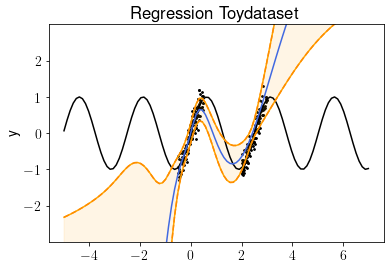

In [1]:
import sys
import torch
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")
from datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader, visualize_predictions
from src.network.feature_extractor import FC_Net
from src.network import LikApprox
import math

torch.manual_seed(2)

data_noise = 0.2
n_datapoints = 256
x_train, y_train, x_test, y_test = create_dataset(lower=-5, upper=7, mapping=sinus_mapping,cluster_pos=[-0.5,2], data_noise=data_noise, n_datapoints=n_datapoints)

lr = 1e-4
weight_decay = 0.1
feature_extractor = FC_Net(layers=[1, 200, 100], nll = torch.nn.Tanh(),lr=lr, weight_decay=weight_decay)

from src.weight_distribution.Full import FullCovariance
dist = FullCovariance(100, 1, lr=lr, init_log_var=-0.5)

from src.network.Regression import LLVIRegression
batch_size = 16
random_permutation = torch.randperm(len(x_train))
x_batch = torch.split(torch.unsqueeze(x_train[random_permutation], dim=1), batch_size)
y_batch =  torch.split(torch.unsqueeze(y_train[random_permutation], dim=1), batch_size)


# prior_log_var = math.log(1/(weight_decay * n_datapoints))
net = LLVIRegression(100, 1, feature_extractor, dist, prior_log_var=-5,
tau=0.01, data_log_var=torch.log(torch.tensor([0.04])),
 lr=lr)
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)

net.train_without_VI(train_set, epochs=100)
net.train_model(train_set, epochs=500, n_datapoints=256, samples=1, method=LikApprox.CLOSEDFORM)

from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
fig, ax1 = plt.subplots(1)
visualize_predictions(net, ax1, x_train, y_train, x_test, y_test, data_noise=data_noise)
ax1.set_title("Regression Toydataset")